In [35]:
import json
import os
import time
import datetime as dt

import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

<H1>1) Simple Stock Analysis:</h1>

In this section, a stock analysis tool is implemented that imports the data of a specific stock within a defined timeframe. It visualizes the stock's closing price changes during that period and includes key metrics such as the Simple Moving Average (SMA), Exponential Moving Average (EMA), Average True Range (ATR), and Daily Return. These metrics help assess the stock's performance, volatility, and daily price movements, providing valuable insights for technical analysis.

In [39]:
# We import the Apple stock during the 2024 period to use as an example
data = yf.download("AAPL", start="2024-01-01", end="2024-12-31")

[*********************100%***********************]  1 of 1 completed


In [41]:
# Calculate SMA and EMA
data['SMA_100'] = data['Close'].rolling(window=100).mean()
data['EMA_100'] = data['Close'].ewm(span=100, adjust=False).mean()

In [43]:
# Calculate the Average of the True Range (ATR) to measure stock volatility
data['High-Low'] = data['High'] - data['Low']
data['High-Close'] = abs(data['High'] - data['Close'].shift(1))
data['Low-Close'] = abs(data['Low'] - data['Close'].shift(1))
data['True_Range'] = data[['High-Low', 'High-Close', 'Low-Close']].max(axis=1)
data['ATR'] = data['True_Range'].rolling(window=14).mean()

In [45]:
# Calculate Daily Return
data['Daily_Return'] = data['Close'].pct_change()

In [ ]:
data.tail() # Display last 5 row to check our values

In [17]:
# Plot the Closing price along with the Simple Moving Average and Exponential Moving Average
def visualize(data):
    plt.figure(figsize=(8,10))
    
    # Plot the price and moving averages
    plt.subplot(2, 1, 1)  # Plotting on the first subplot
    plt.plot(data.index, data['Close'], label='Close Price', color='blue')
    plt.plot(data.index, data['SMA_100'], label='SMA 100', linestyle='--', color='orange')
    plt.plot(data.index, data['EMA_100'], label='EMA 100', linestyle='-', color='green')
    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.title('Closing Price')
    plt.legend()

    # Plot ATR and Daily Return
    plt.subplot(2, 1, 2)  # Plotting on the second subplot
    plt.plot(data.index, data['ATR'], label='ATR', color='red', linestyle='-')
    plt.plot(data.index, data['Daily_Return'], label='Daily Return', color='purple', linestyle='--')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.title('ATR and Daily Return')
    plt.legend()

    plt.tight_layout()
    plt.show()


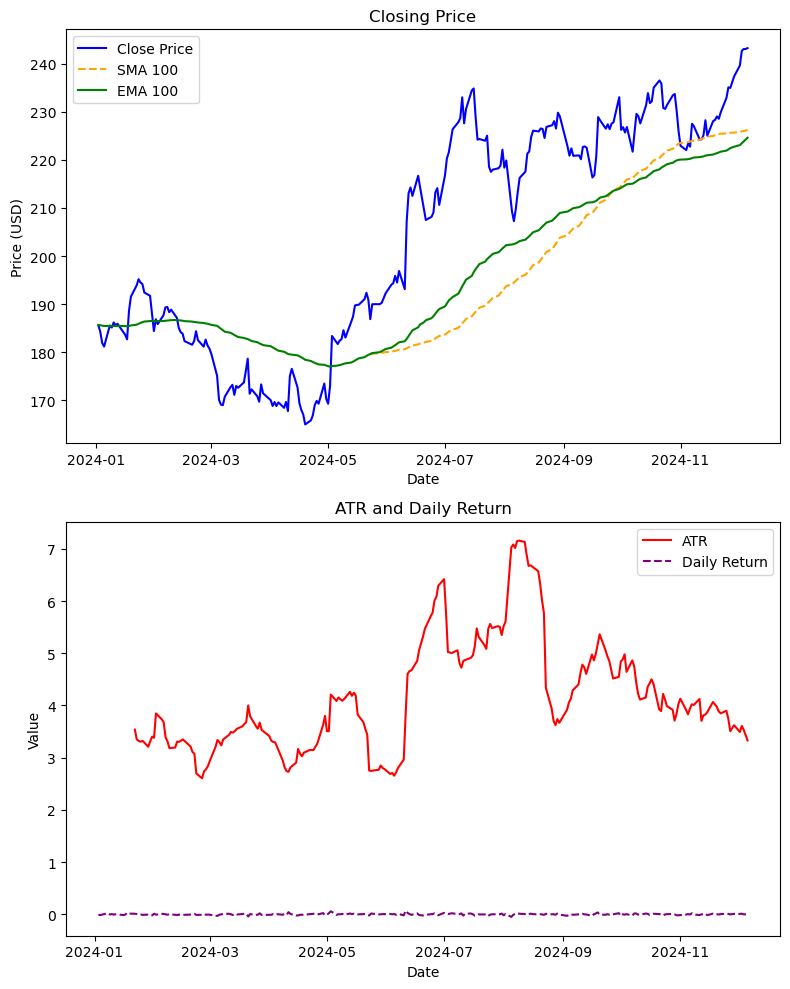

In [19]:
visualize(data)

<H1>2) Watchlist Management and Visualization:</H1>

The Watchlist class allows users to manage a dynamic list of stock symbols for monitoring in real-time. It provides functionalities to add, remove, and view stocks in the watchlist, as well as save and load the watchlist data from a JSON file for persistent storage. The class also enables real-time data fetching for each stock in the watchlist through the yfinance API and visualizes the stock prices over time.

In [23]:
class Watchlist:
    def __init__(self, filename="watchlist.json"):
        """
        Initialize the watchlist object.

        Parameters:
            filename (str): The file to save/load the watchlist (default: "watchlist.json").
        """
        self.filename = filename
        self.watchlist = self._load_watchlist()

    def _load_watchlist(self):
        """Load the watchlist from a file or create an empty one."""
        if os.path.exists(self.filename):
            with open(self.filename, 'r') as file:
                return json.load(file)
        return []

    def _save_watchlist(self):
        """Save the watchlist to a file."""
        with open(self.filename, 'w') as file:
            json.dump(self.watchlist, file)

    def add(self, symbol):
        """
        Add a stock symbol to the watchlist.

        Parameters:
            symbol (str): The stock symbol to add.
        """
        symbol = symbol.upper()
        if symbol not in self.watchlist:
            self.watchlist.append(symbol)
            print(f"{symbol} added to your watchlist.")
            self._save_watchlist()
        else:
            print(f"{symbol} is already in your watchlist.")

    def remove(self, symbol):
        """
        Remove a stock symbol from the watchlist.

        Parameters:
            symbol (str): The stock symbol to remove.
        """
        symbol = symbol.upper()
        if symbol in self.watchlist:
            self.watchlist.remove(symbol)
            print(f"{symbol} removed from your watchlist.")
            self._save_watchlist()
        else:
            print(f"{symbol} is not in your watchlist.")

    def view(self):
        """View the current watchlist."""
        if self.watchlist:
            print("Your watchlist contains the following symbols:")
            print(", ".join(self.watchlist))
        else:
            print("Your watchlist is empty.")

    def get_watchlist(self):
        """
        Return the watchlist as a list.
        
        Returns:
            list: The current watchlist.
        """
        return self.watchlist

    def fetch_data(self, symbol):
        """
        Fetch real-time stock data for a given symbol.
    
        Parameters:
            symbol (str): The stock symbol.
    
        Returns:
            pd.DataFrame: The real-time stock data.
        """
        try:
            stock = yf.Ticker(symbol)
            data = stock.history(period="1d", interval="1m")  # Fetch 1-day, 1-minute interval data
            if data.empty:
                print(f"Failed to fetch data for {symbol}.")
                return None
            return data
        except Exception as e:
            print(f"Error fetching data for {symbol}: {e}")
            return None

    def plot_data(self, symbol, data):
        """Helper function to plot stock data."""
        plt.plot(data.index, data['Close'], label=f'{symbol} Real-Time Price')

    def visualize(self):
        """Visualize real-time stock prices for all symbols in the watchlist."""
        symbols = self.get_watchlist()
        if not symbols:
            print("Your watchlist is empty. Add some stocks first.")
            return
        
        plt.figure(figsize=(14, 8))
        
        for symbol in symbols:
            data = self.fetch_data(symbol)
            if data is not None:
                self.plot_data(symbol, data)
                time.sleep(1)  # Adding a small delay to prevent hitting rate limits

        plt.xlabel('Time')
        plt.ylabel('Price (USD)')
        plt.title('Real-Time Stock Prices for the Watchlist')
        plt.legend()
        plt.grid()
        
        # Formatting the x-axis to show time
        date_formatter = DateFormatter("%H:%M")
        plt.gca().xaxis.set_major_formatter(date_formatter)
        
        plt.show()
        plt.clf()  # Clear the current plot to avoid overlap in future visualizations

In [25]:
# Example Usage
watchlist = Watchlist()

In [27]:
# Add stocks to portfolio
watchlist.add("AAPL")
watchlist.add("MSFT")
watchlist.add("GOOGL")
watchlist.add("NVDA")
watchlist.remove("BTC")

AAPL is already in your watchlist.
MSFT is already in your watchlist.
GOOGL is already in your watchlist.
NVDA is already in your watchlist.
BTC is not in your watchlist.


In [29]:
# View watchlist stocks
watchlist.view()

Your watchlist contains the following symbols:
AAPL, MSFT, GOOGL, NVDA


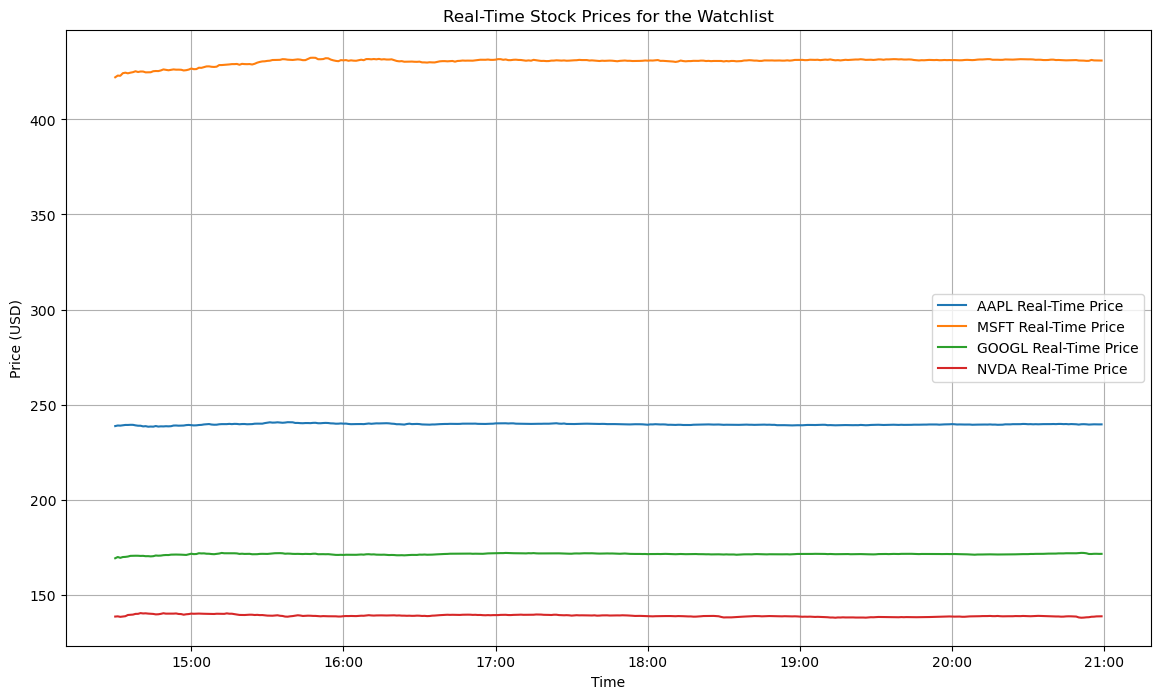

<Figure size 640x480 with 0 Axes>

In [23]:
# Visualize real-time data for all stocks in the watchlist
watchlist.visualize()

<H1>3) Portfolio Management and Visualization:</H1>

The Portfolio class enables users to manage and track their stock portfolio, allowing for the addition, removal, and updating of stock holdings. It supports saving and loading portfolio data from a JSON file, ensuring that the portfolio remains persistent across sessions. The class also fetches real-time stock prices using the yfinance API and calculates the value of each stock holding in the portfolio. Additionally, it provides visualization of the portfolio's allocation and total value.

In [31]:
class Portfolio:
    def __init__(self, filename="portfolio.json"):
        """
        Initialize the Portfolio object.

        Parameters:
            filename (str): The file to save/load the portfolio (default: "portfolio.json").
        """
        self.filename = filename
        self.portfolio = self._load_portfolio()

    def _load_portfolio(self):
        """Load the portfolio from a file or create an empty one."""
        if os.path.exists(self.filename):
            with open(self.filename, 'r') as file:
                try:
                    data = json.load(file)
                    if isinstance(data, dict):
                        return data
                    else:
                        print("Invalid data format in file. Resetting portfolio to an empty dictionary.")
                        return {}
                except json.JSONDecodeError:
                    print("Error decoding JSON. Resetting portfolio to an empty dictionary.")
                    return {}
        return {}

    def _save_portfolio(self):
        """Save the portfolio to a file."""
        with open(self.filename, 'w') as file:
            json.dump(self.portfolio, file)

    def add(self, symbol, shares):
        """
        Add a stock symbol with the number of shares to the portfolio.

        Parameters:
            symbol (str): The stock symbol to add.
            shares (int): The number of shares owned.
        """
        symbol = symbol.upper()
        if symbol in self.portfolio:
            print(f"{symbol} already in portfolio. Updating shares.")
            self.portfolio[symbol] += shares
        else:
            self.portfolio[symbol] = shares
            print(f"{symbol} added to your portfolio with {shares} shares.")
        self._save_portfolio()

    def update(self, symbol, shares):
        """
        Update the number of shares for an existing stock.

        Parameters:
            symbol (str): The stock symbol to update.
            shares (int): The updated number of shares owned.
        """
        symbol = symbol.upper()
        if symbol in self.portfolio:
            self.portfolio[symbol] = shares
            print(f"{symbol} shares updated to {shares}.")
        else:
            print(f"{symbol} is not in your portfolio. Use add() instead.")
        self._save_portfolio()

    def remove(self, symbol):
        """
        Remove a stock symbol from the portfolio.

        Parameters:
            symbol (str): The stock symbol to remove.
        """
        symbol = symbol.upper()
        if symbol in self.portfolio:
            del self.portfolio[symbol]
            print(f"{symbol} removed from your portfolio.")
            self._save_portfolio()
        else:
            print(f"{symbol} is not in your portfolio.")

    def view(self):
        """View the current portfolio."""
        if self.portfolio:
            print("Your portfolio contains the following stocks and shares:")
            for symbol, shares in self.portfolio.items():
                print(f"{symbol}: {shares} shares")
        else:
            print("Your portfolio is empty.")

    def fetch_stock_prices(self):
        """
        Fetch the latest stock prices for the portfolio.

        Returns:
            dict: A dictionary with stock symbols as keys and their latest prices as values.
        """
        prices = {}
        for symbol in self.portfolio:
            try:
                stock = yf.Ticker(symbol)
                price = stock.history(period="1d")["Close"].iloc[-1]
                prices[symbol] = price
            except Exception as e:
                print(f"Error fetching price for {symbol}: {e}")
                prices[symbol] = None
        return prices

    def visualize(self):
        """Visualize the portfolio allocation based on stock worth and show the total worth."""
        if not self.portfolio:
            print("Your portfolio is empty. Add some stocks first.")
            return

        stock_prices = self.fetch_stock_prices()
        total_worth = 0
        worth_per_stock = {}

        for symbol, shares in self.portfolio.items():
            price = stock_prices.get(symbol)
            if price is not None:
                worth = price * shares
                worth_per_stock[symbol] = worth
                total_worth += worth
            else:
                print(f"Skipping {symbol} due to missing price data.")

        if not worth_per_stock:
            print("No valid data to visualize.")
            return

        labels = worth_per_stock.keys()
        sizes = worth_per_stock.values()

        plt.figure(figsize=(8, 8))
        plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=plt.cm.tab20.colors)
        plt.title(f'Portfolio Allocation\n (Total Value: ${total_worth:,.2f})')
        plt.axis('equal')
        plt.show()

    def get_portfolio(self):
        """
        Return the portfolio as a dictionary.

        Returns:
            dict: The current portfolio.
        """
        return self.portfolio


AAPL already in portfolio. Updating shares.
MSFT already in portfolio. Updating shares.
GOOGL already in portfolio. Updating shares.
Your portfolio contains the following stocks and shares:
AAPL: 90 shares
MSFT: 180 shares
GOOGL: 135 shares


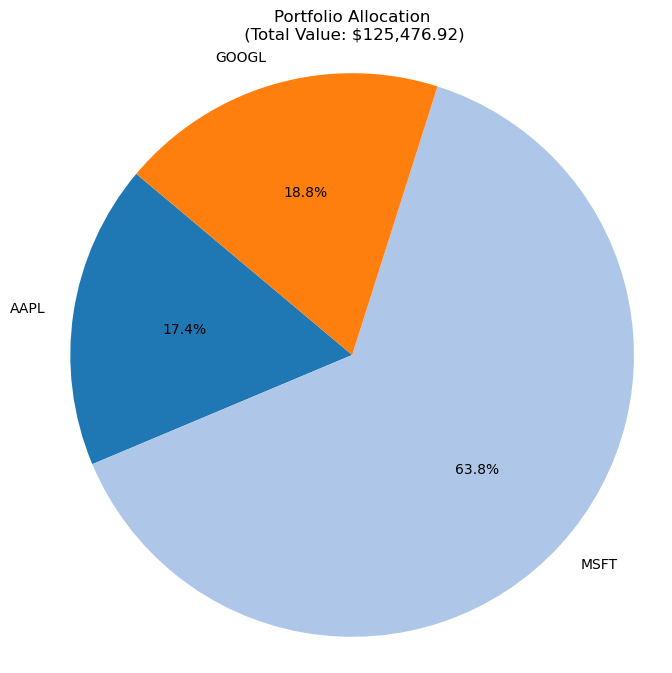

In [33]:
portfolio = Portfolio()
portfolio.add("AAPL", 10)
portfolio.add("MSFT", 20)
portfolio.add("GOOGL", 15)

# View portfolio
portfolio.view()

# Visualize portfolio by stock worth
portfolio.visualize()
